<a href="https://colab.research.google.com/github/yeabwang/tensorflow/blob/main/Malaria_diagnosis_functional_API_%26model_subclassing%26custommodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from google.colab import drive

In [ ]:
dataset,dataset_info = tfds.load('malaria',as_supervised=True,with_info=True, shuffle_files = True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [27]:
# Spliting our dataset into trianing, validation and testing

def split_dataset(dataset, train_ratio, val_ratio, test_ratio):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()

    train_dataset = dataset.take(int(train_ratio * dataset_size))  # Training set
    val_test_dataset = dataset.skip(int(train_ratio * dataset_size))  # Remaining
    val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))  # Validation set
    test_dataset = val_test_dataset.skip(int(val_ratio * dataset_size))  # Test set

    return train_dataset, val_dataset, test_dataset


In [28]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset,val_dataset,test_dataset = split_dataset(dataset[0],train_ratio,val_ratio,test_ratio)

In [29]:
# Resizing and Rescaling

image_size = 224

def resize_rescale(image, label):
    image = tf.image.resize(image, [image_size, image_size])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [30]:
#shuffling and taking a batch of our dataset

batch_size = 32
channel_size = 3

# For the training dataset
train_dataset = (
    train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# For the validation dataset
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# For the test dataset
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Functional API


In [7]:
# Feature Extraction Model

func_input = Input(shape=(image_size, image_size, channel_size), name = 'input_image')

# First layer
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2, strides=2)(x)

# Second Layer
x = Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=2, strides=2)(x)

# Third Layer
x = Conv2D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
feature_output = MaxPooling2D(pool_size=2, strides=2)(x)

feature_extractor_model = Model(inputs=func_input, outputs=feature_output, name='feature_extractor_model')

feature_extractor_model.summary()

Model: "feature_extractor_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,632 (365.75 KB)

 Trainable params: 93,440 (365.00 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Classification Model

func_input = Input(shape=(image_size, image_size, channel_size), name = 'input_image')

class_fun = feature_extractor_model(func_input)
# Dense Layer
x = Flatten()(class_fun)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.5)(x)

class_output = Dense(units=1, activation='sigmoid')(x)

# Our Model
class_fun_model  = Model(inputs=func_input, outputs=class_output, name='cell_classification_model')

class_fun_model.summary()

Model: "cell_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extractor_model (Functional) │ (None, 26, 26, 128)         │          93,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,261,569 (84.92 MB)

 Trainable params: 22,261,377 (84.92 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
func_input = Input(shape=(image_size, image_size, channel_size), name = 'input_image')

class_fun = feature_extractor_subclass(func_input)
# Dense Layer
x = Flatten()(class_fun)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.5)(x)

class_output = Dense(units=1, activation='sigmoid')(x)

# Our Model
class_fun_model  = Model(inputs=func_input, outputs=class_output, name='cell_classification_model')

class_fun_model.summary()

Model: "cell_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extractor_7                  │ (None, 54, 54, 64)          │          19,776 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │      47,776,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,812,289 (182.39 MB)

 Trainable params: 47,812,097 (182.39 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Compiling our functional model

class_fun_model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(from_logits=False), metrics=['accuracy', 'AUC'])

In [31]:
# Setting regularizations

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Save the best model during training
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
# Training our model

history = class_fun_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Model Subclassing

In [20]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()

        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.max_pool_1 = MaxPooling2D(pool_size=pool_size, strides=strides)  # Normal stride, not 2*strides

        self.conv_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.max_pool_2 = MaxPooling2D(pool_size=pool_size, strides=strides)  # Normal stride

    def call(self, x):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.max_pool_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.max_pool_2(x)

        return x

feature_extractor_subclass = FeatureExtractor(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu', pool_size=2)


In [41]:
# Building our class Model

class ClassificationModel(Model):
    def __init__(self):
        super(ClassificationModel, self).__init__()

        self.feature_extractor = FeatureExtractor(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu', pool_size=2)
        self.flatten = Flatten()
        self.dense_1 = Dense(units=32, activation='relu')
        self.batch_1 = BatchNormalization()
        self.dropout_1 = Dropout(0.5)

        self.dense_2 = Dense(units=10, activation='relu')
        self.batch_2 = BatchNormalization()
        self.dropout_2 = Dropout(0.5)

        self.dense_3 = Dense(units=1, activation='sigmoid')

    def call(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dropout_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dropout_2(x)
        x = self.dense_3(x)
        return x

# Create model instance
class_model = ClassificationModel()

# dummy data
class_model(tf.zeros([1, 224, 224, 3]))

class_model.summary()


Model: "classification_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extractor_7                  │ ?                           │           1,488 │
│ (FeatureExtractor)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (1, 760384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (1, 32)                     │      24,332,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (1, 32)                     │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (1, 32)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (1, 10)                     │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (1, 10)                     │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (1, 10)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (1, 1)                      │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,334,317 (92.83 MB)

 Trainable params: 24,334,185 (92.83 MB)

 Non-trainable params: 132 (528.00 B)

In [42]:
# Compiling our model

class_model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(from_logits=False), metrics=['accuracy', 'AUC'])

In [43]:
# Fitting our model

class_history = class_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - AUC: 0.7099 - accuracy: 0.6617 - loss: 0.7328
Epoch 1: val_loss improved from inf to 0.25230, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 77s 99ms/step - AUC: 0.7101 - accuracy: 0.6619 - loss: 0.7325 - val_AUC: 0.9641 - val_accuracy: 0.8911 - val_loss: 0.2523 - learning_rate: 0.0010
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - AUC: 0.9567 - accuracy: 0.9004 - loss: 0.2625
Epoch 2: val_loss improved from 0.25230 to 0.23953, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 60s 85ms/step - AUC: 0.9567 - accuracy: 0.9005 - loss: 0.2624 - val_AUC: 0.9651 - val_accuracy: 0.9005 - val_loss: 0.2395 - learning_rate: 0.0010
Epoch 3/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - AUC: 0.9733 - accuracy: 0.9253 - loss: 0.2037
Epoch 3: val_loss improved from 0.23953 to 0.18760, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 87s 92ms/step - AUC: 0.9733 - accuracy: 0.9253 - loss: 0.2036 - val

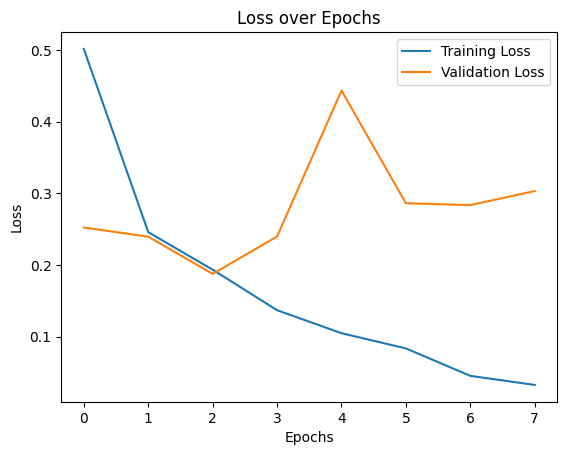

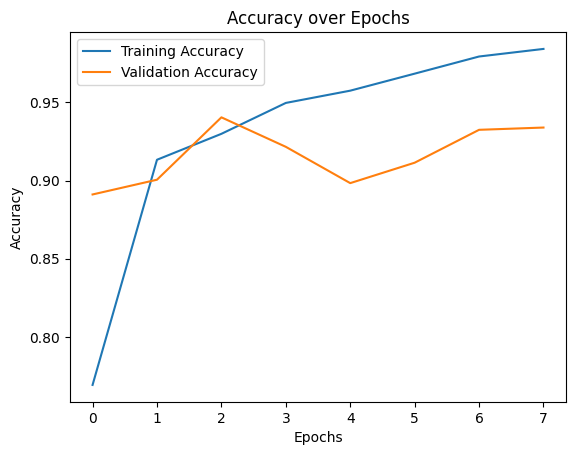

In [44]:
# Plot training and validation loss
plt.plot(class_history.history['loss'], label='Training Loss')
plt.plot(class_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(class_history.history['accuracy'], label='Training Accuracy')
plt.plot(class_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Custom Layers


In [32]:
class CustomMalariaDense(Layer):
    def __init__(self, output_units, activation):
        super(CustomMalariaDense, self).__init__()
        self.output_units = output_units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_feature_shape):
        self.kernel = self.add_weight(
            shape=(input_feature_shape[-1], self.output_units),
            initializer='random_normal',
            trainable=True,
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(self.output_units,),
            initializer='random_normal',
            trainable=True,
            name='bias'
        )

    def call(self, input_feature):
        linear_output = tf.matmul(input_feature, self.kernel) + self.bias
        return self.activation(linear_output)



In [33]:
# Model definition
channel_size = 3
image_size = 224

custom_model = Sequential([
    InputLayer(shape=(image_size, image_size, channel_size)),

    # First Convolutional Block
    Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Second Convolutional Block
    Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Third Convolutional Block (Optional)
    Conv2D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),

    # Dense Layers
    Flatten(),
    CustomMalariaDense(256, activation='relu'),
    Dropout(0.5),
    CustomMalariaDense(64, activation='relu'),
    Dropout(0.5),
    CustomMalariaDense(1, activation='sigmoid')
])

custom_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_malaria_dense_9               │ (None, 256)                 │      22,151,424 │
│ (CustomMalariaDense)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_malaria_dense_10              │ (None, 64)                  │          16,448 │
│ (CustomMalariaDense)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ custom_malaria_dense_11              │ (None, 1)                   │              65 │
│ (CustomMalariaDense)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,261,185 (84.92 MB)

 Trainable params: 22,261,185 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Compiling our model

custom_model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = BinaryCrossentropy(from_logits=False),
    metrics = ['accuracy', 'AUC']
)

In [35]:
custom_history = custom_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - AUC: 0.8098 - accuracy: 0.7411 - loss: 0.4999
Epoch 1: val_loss improved from inf to 0.18096, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 70s 93ms/step - AUC: 0.8100 - accuracy: 0.7413 - loss: 0.4997 - val_AUC: 0.9833 - val_accuracy: 0.9361 - val_loss: 0.1810 - learning_rate: 0.0010
Epoch 2/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - AUC: 0.9772 - accuracy: 0.9494 - loss: 0.1688
Epoch 2: val_loss improved from 0.18096 to 0.17105, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - AUC: 0.9772 - accuracy: 0.9494 - loss: 0.1688 - val_AUC: 0.9834 - val_accuracy: 0.9466 - val_loss: 0.1711 - learning_rate: 0.0010
Epoch 3/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - AUC: 0.9837 - accuracy: 0.9592 - loss: 0.1395
Epoch 3: val_loss improved from 0.17105 to 0.14386, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - AUC: 0.9837 - accuracy: 0.9592 - loss: 0.1395 - val

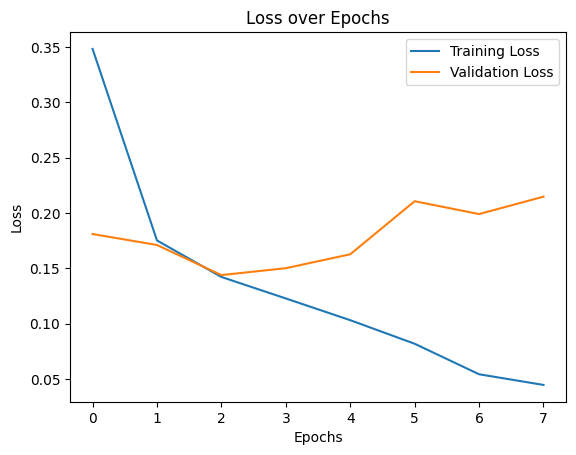

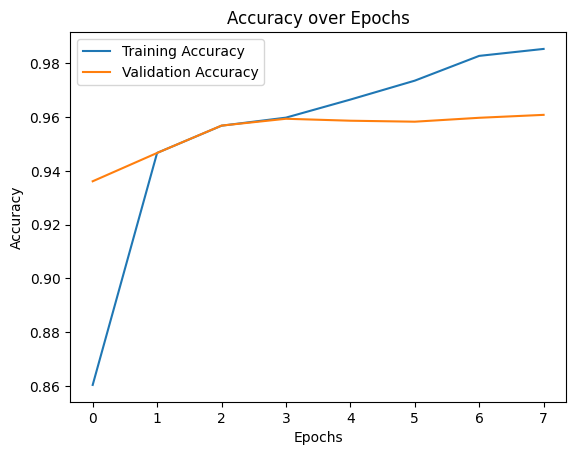

In [36]:
# Plot training and validation loss
plt.plot(custom_history.history['loss'], label='Training Loss')
plt.plot(custom_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(custom_history.history['accuracy'], label='Training Accuracy')
plt.plot(custom_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()